# 수치형변수 가공 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from warnings import simplefilter

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
simplefilter('ignore')

## 학습데이터 로드

학습데이터는 데이콘 [영화 관객수 예측 모델 개발](https://dacon.io/competitions/open/235536/data/) 페이지에서 다운로드하여 `../data/movies/` 폴더에 저장해 둔다.

이 데이터는 영화의 장르, 개봉일, 상영시간 등과 같은 데이터로 영화 총 관객수 (`box_off_num`)를 예측하는 데이터이다.

In [4]:
data_dir = Path('./data/movies/')
trn_file = data_dir / 'movies_train.csv'
seed = 42

In [5]:
df = pd.read_csv(trn_file, index_col=0)
print(df.shape)
df.head()

(600, 11)


,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
title,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


## EDA (Exploratory Data Analysis)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 개들의 전쟁 to 베를린
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   director        600 non-null    object 
 6   dir_prev_bfnum  270 non-null    float64
 7   dir_prev_num    600 non-null    int64  
 8   num_staff       600 non-null    int64  
 9   num_actor       600 non-null    int64  
 10  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 56.2+ KB


독립변수를 포함 총 6개의 수치형변수가 있다. 그 중 `dir_prev_bfnum`은 결측값이 많음을 확인할 수 있다.

In [7]:
df.fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 개들의 전쟁 to 베를린
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   director        600 non-null    object 
 6   dir_prev_bfnum  600 non-null    float64
 7   dir_prev_num    600 non-null    int64  
 8   num_staff       600 non-null    int64  
 9   num_actor       600 non-null    int64  
 10  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 56.2+ KB


결측값을 0으로 대체하였다.

In [8]:
df.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,4.726993e+05,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.309474e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,0.000000e+00,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,3.761416e+05,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


수치형변수의 분포로부터 모든 수치형변수가 0이나 양수의 값을 가짐을 알 수 있다.

In [9]:
target_col = 'box_off_num'
pred_col = 'pred'
num_cols = [x for x in df.columns if df[x].dtype in [np.int64, np.float64] and x != target_col]
print(num_cols)

['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']


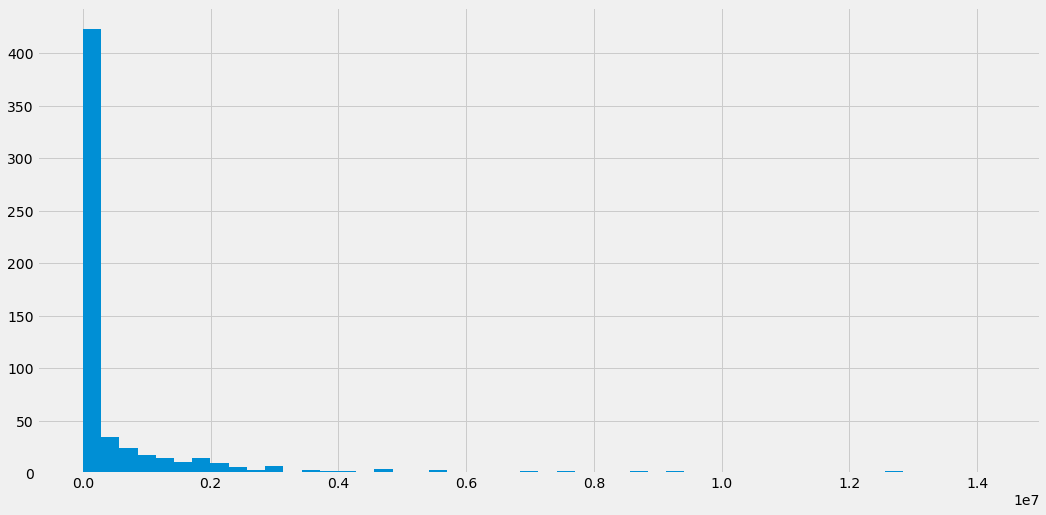

In [10]:
df.box_off_num.hist(bins=50)

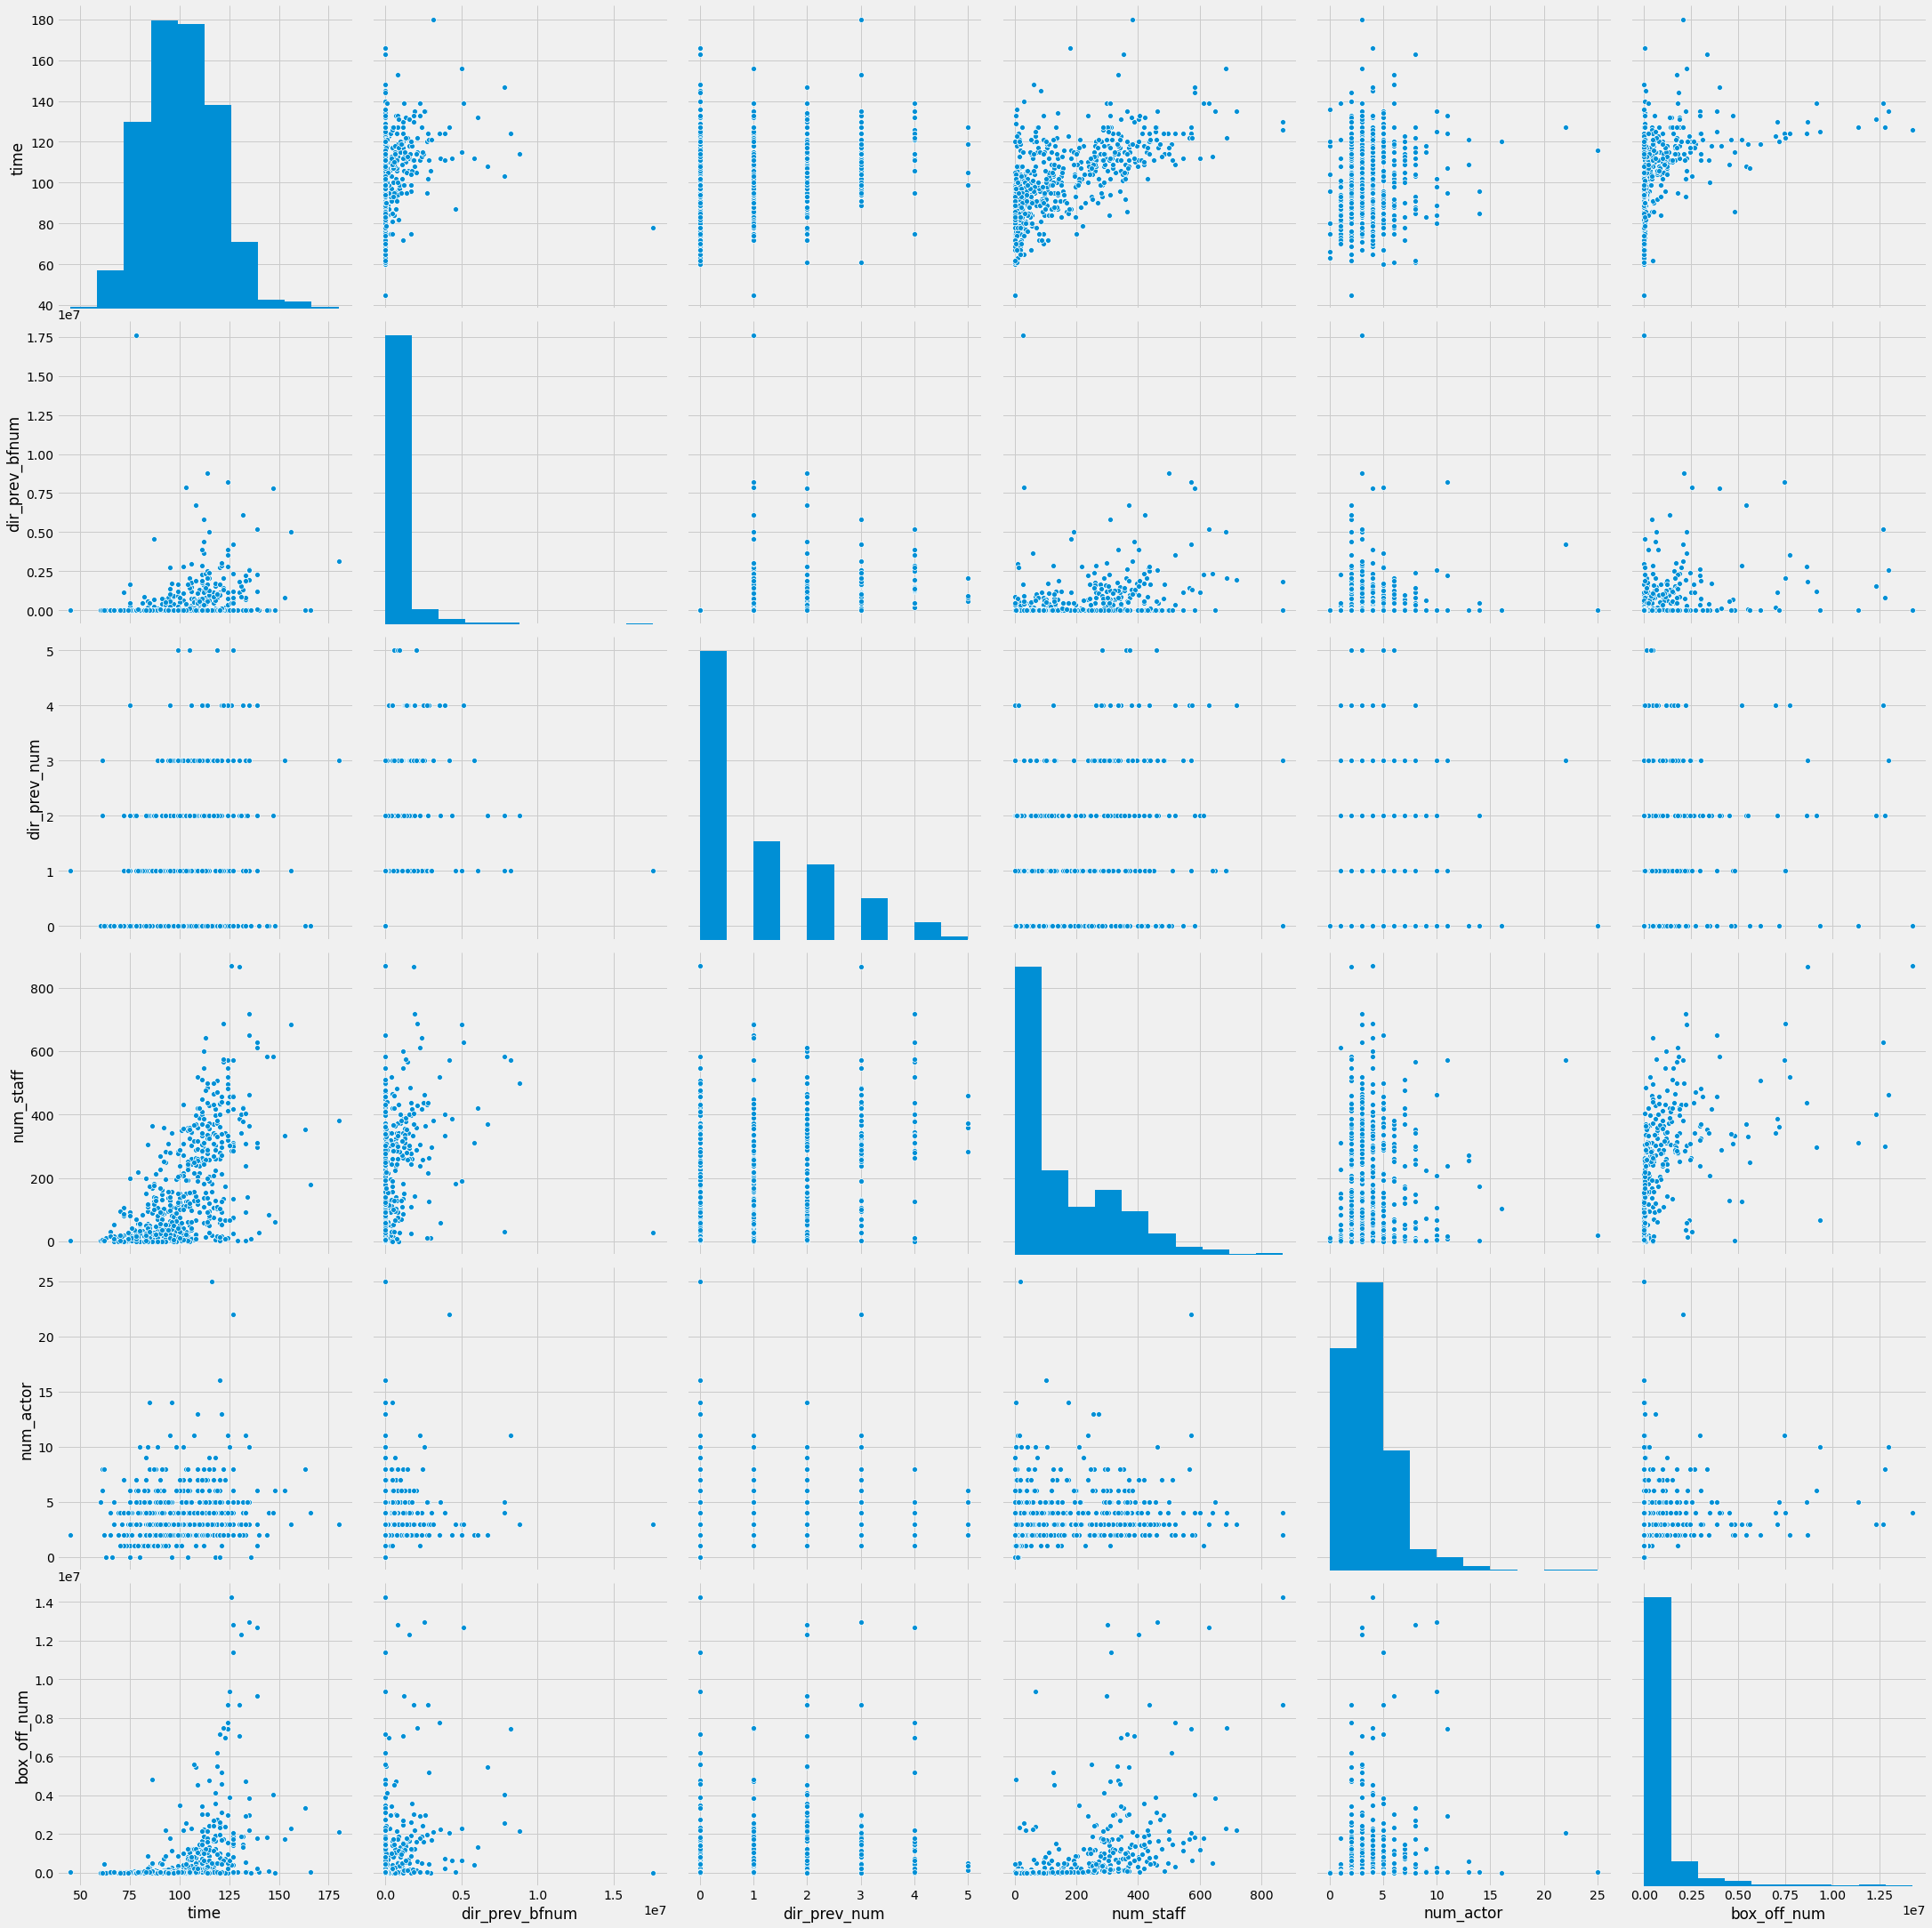

In [11]:
sns.pairplot(data=df, vars=num_cols + [target_col], size=5)

수치형변수 중 `time`은 정규분포에 가깝고 나머지는 멱함수 (power-law)분포에 가깝다.

In [12]:
df.corr().style.background_gradient()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.266065,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.266065,1.000000,0.396616,0.369657,0.042491,0.293791
dir_prev_num,0.306727,0.396616,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.369657,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.042491,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.293791,0.259674,0.544265,0.111179,1.000000


## 선형회귀 모델 학습

### RMSE/RMLSE 손실함수 정의

In [13]:
rmse = lambda y, p: np.sqrt(mean_squared_error(y, p))
rmlse = lambda y, p: np.sqrt(mean_squared_error(np.log1p(y), np.log1p(p)))

### 변수 가공없이 선형회귀 모델 학습

In [14]:
lr = LinearRegression()
lr.fit(df[num_cols], df[target_col])
df[pred_col] = lr.predict(df[num_cols])

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1500066.43


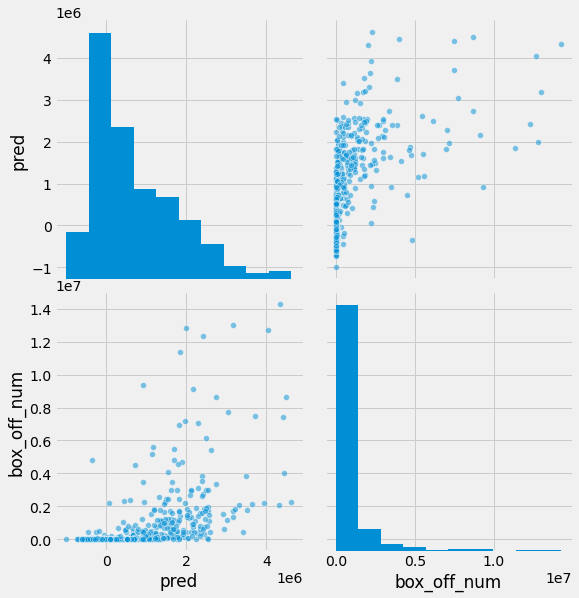

In [15]:
sns.pairplot(data=df, vars=[pred_col, target_col], size=4, plot_kws={'alpha': .5})

예측값 중 음수가 존재하고 큰 값의 예측은 비교적 정확한 반면 적은 값의 예측은 오차가 많이 발생하였다.

### 멱함수 분포 변수 `log1p` 변환(정규분호에 가깝게 변환)

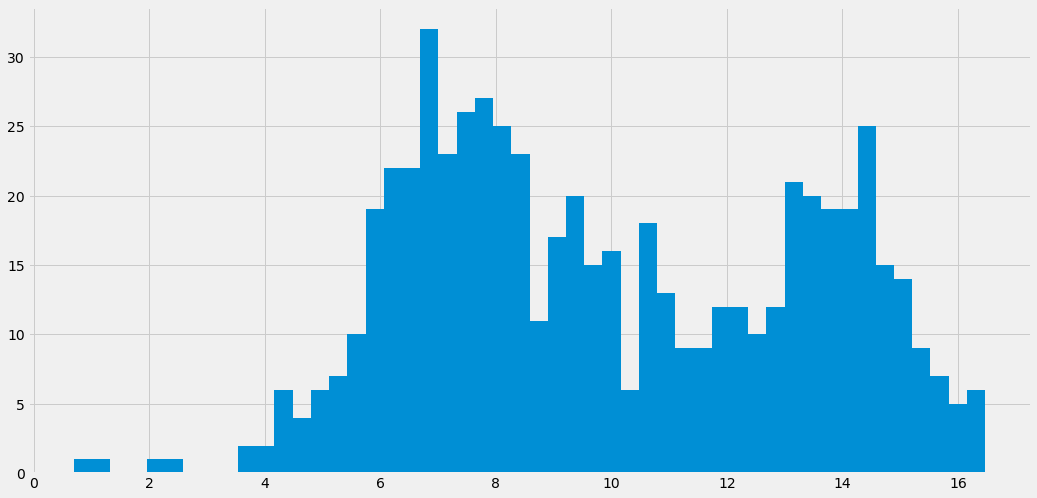

In [16]:
df.box_off_num.apply(np.log1p).hist(bins=50)

멱함수 분포의 수치형 변수는 `np.log1p()` 함수로 정규분포에 가깝게 변환할 수 있다. 역변환은 `np.expm1()` 함수를 이용하면 된다.

In [17]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
#학습된 데이터를 다시 역변환 시켜준다
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	 17129211.69
RMLSE:	        2.12


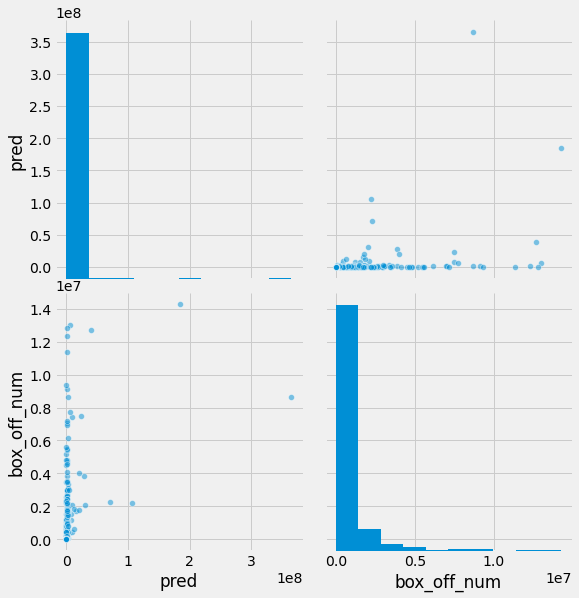

In [18]:
sns.pairplot(data=df, vars=[pred_col, target_col], size=4, plot_kws={'alpha': .5})

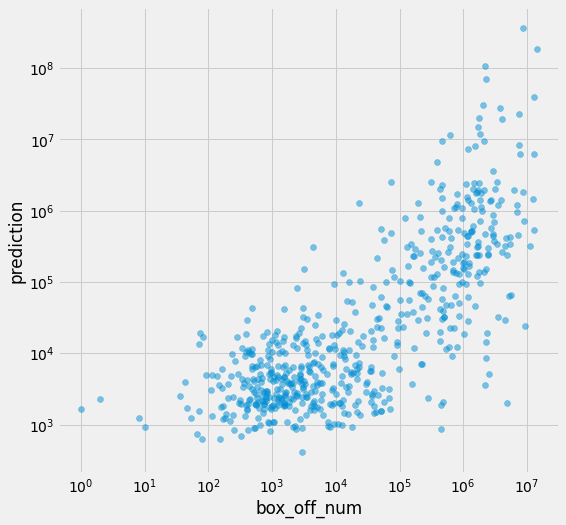

In [19]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

In [20]:
df[num_cols].describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,600.000000,6.000000e+02,600.000000,600.000000,600.000000
mean,100.863333,4.726993e+05,0.876667,151.118333,3.706667
std,18.097528,1.309474e+06,1.183409,165.654671,2.446889
min,45.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,89.000000,0.000000e+00,0.000000,17.000000,2.000000
50%,100.000000,0.000000e+00,0.000000,82.500000,3.000000
75%,114.000000,3.761416e+05,2.000000,264.000000,4.000000
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000


In [21]:
df[['dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']] = df[['dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor']].apply(np.log1p)
df[num_cols].describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,100.863333,5.305796,0.462197,4.026352,1.446130
std,18.097528,6.254561,0.555570,1.789517,0.446256
min,45.000000,0.000000,0.000000,0.000000,0.000000
25%,89.000000,0.000000,0.000000,2.890372,1.098612
50%,100.000000,0.000000,0.000000,4.424829,1.386294
75%,114.000000,12.837611,1.098612,5.579730,1.609438
max,180.000000,16.684279,1.791759,6.768493,3.258097


수치형 독립변수 중 멱변환 분포를 따르는 변수에도 `np.log1p()` 변환을 적용하였다.

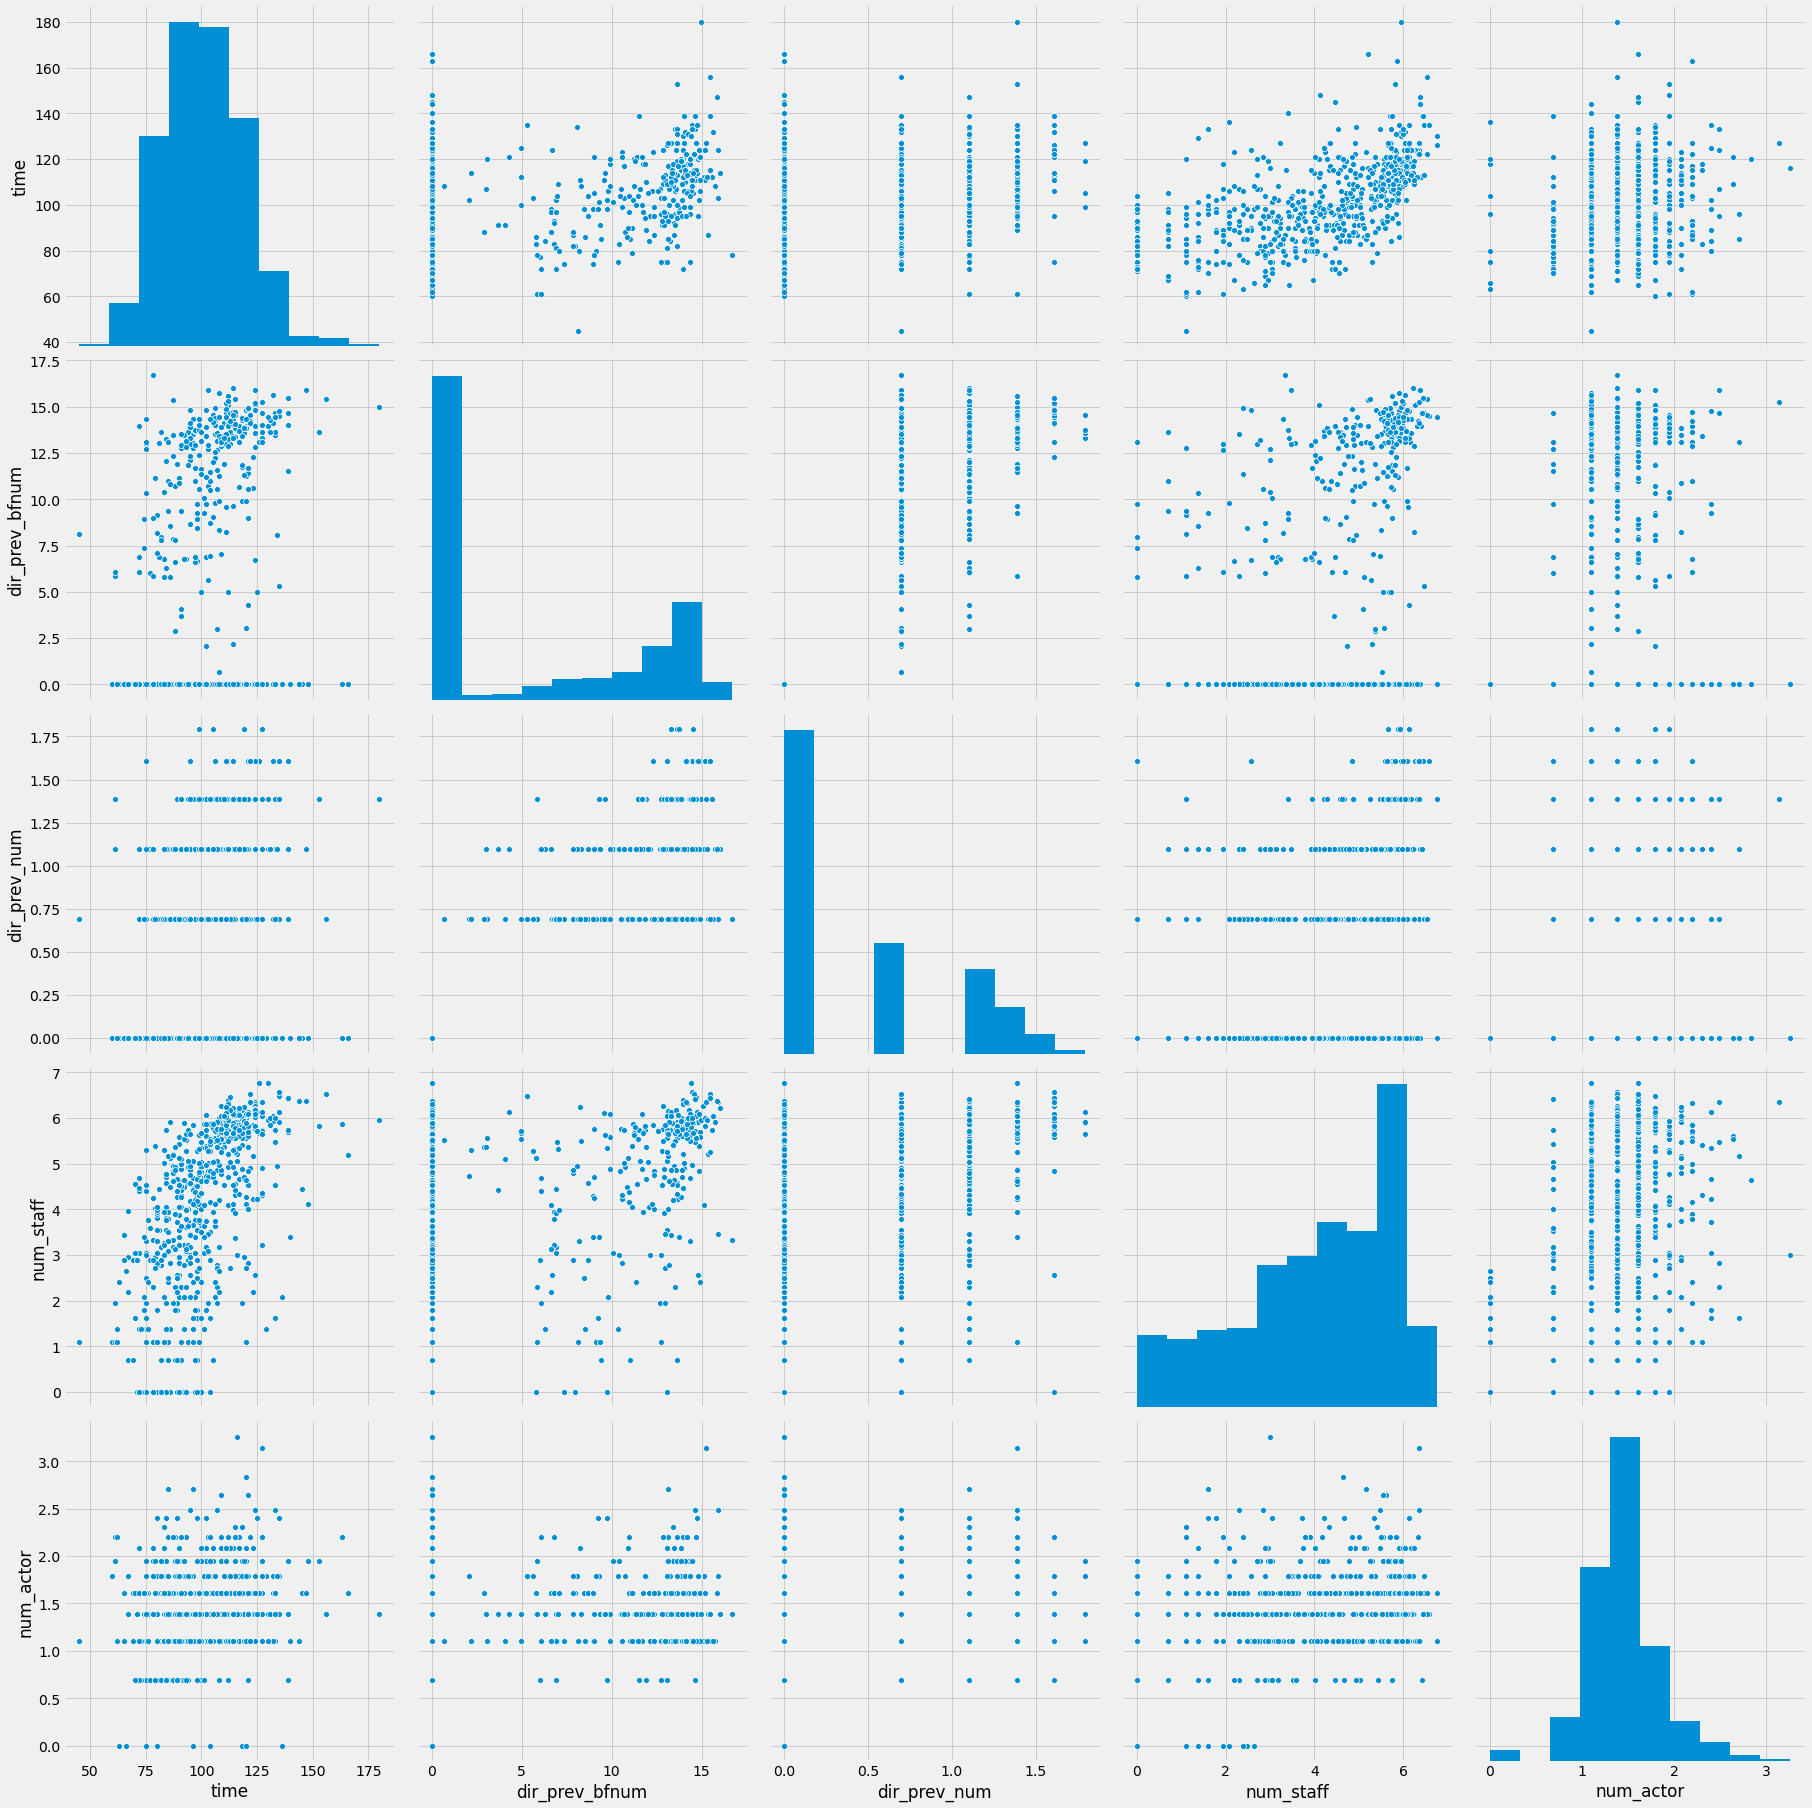

In [22]:
sns.pairplot(data=df, vars=num_cols, size=5)

In [23]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1883568.88
RMLSE:	        2.32


RMLSE는 조금 나빠졌지만 RMSE는 크게 개선이 되었다.

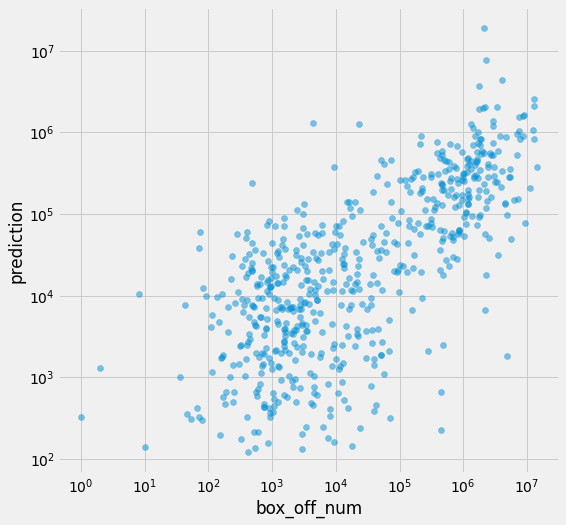

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

In [25]:
df.head()

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,pred
title,,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.000000,0.000000,4.521789,1.098612,23398,12093.438433
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,13.965312,1.098612,5.961005,1.386294,7072501,963891.149247
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,12.304905,1.609438,5.840642,1.609438,6959083,521738.259465
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,10.081425,1.098612,3.044522,1.945910,217866,19533.298119
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,0.693147,0.693147,5.529429,1.098612,483387,50007.266863


### 날짜/시간 변수 처리

In [26]:
df['release_time'] = pd.to_datetime(df['release_time'])
df['release_time'].describe()

count                     600
unique                    330
top       2015-08-13 00:00:00
freq                        6
first     2010-01-02 00:00:00
last      2015-12-31 00:00:00
Name: release_time, dtype: object

In [27]:
df['year'] = df['release_time'].dt.year
df['month'] = df['release_time'].dt.month
df.head()

,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,pred,year,month
title,,,,,,,,,,,,,,
개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.000000,0.000000,4.521789,1.098612,23398,12093.438433,2012,11
내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,13.965312,1.098612,5.961005,1.386294,7072501,963891.149247,2015,11
은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,12.304905,1.609438,5.840642,1.609438,6959083,521738.259465,2013,6
나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,10.081425,1.098612,3.044522,1.945910,217866,19533.298119,2012,7
불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,0.693147,0.693147,5.529429,1.098612,483387,50007.266863,2010,11


In [28]:
# 날짜 시간 변수 추가
num_cols += ['year', 'month']
print(num_cols)

['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'year', 'month']


In [29]:
lr = LinearRegression()
lr.fit(df[num_cols], np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(df[num_cols]))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1893420.63
RMLSE:	        2.31


### 정규화/스케일링

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [31]:
scaler = StandardScaler()
X = scaler.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1893420.63
RMLSE:	        2.31


In [32]:
scaler = MinMaxScaler()# min값과 max 값을 0 과 1 로 고정 시킨다. Ex) max=100이면 모두 100으로 나눈다.
X = scaler.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1893420.63
RMLSE:	        2.31


### Binning(수치형을 범주형 변수으로 변화 가능)

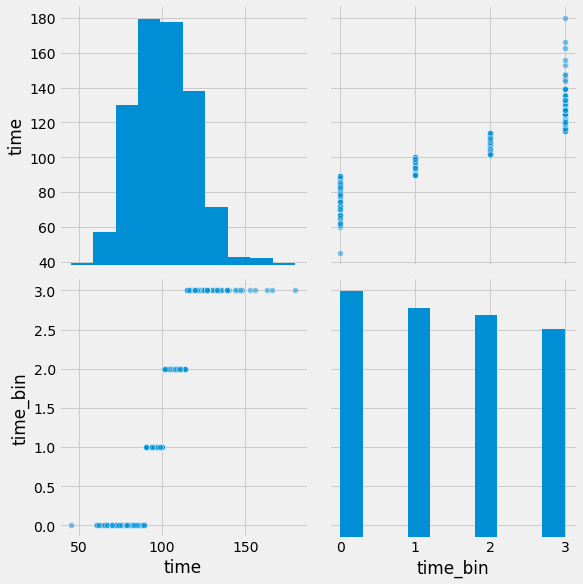

In [33]:
df['time_bin'] = pd.qcut(df['time'], 4, labels=False)
sns.pairplot(data=df, vars=['time', 'time_bin'], size=4, plot_kws={'alpha': .5})

In [34]:
df['time_bin'] = pd.qcut(df['time'], 4, labels=False)
df[['time', 'time_bin']].head(10)

,time,time_bin
title,,
개들의 전쟁,96,1
내부자들,130,3
은밀하게 위대하게,123,3
나는 공무원이다,101,2
불량남녀,108,2
강철대오 : 구국의 철가방,113,2
길위에서,104,2
회사원,96,1
"1789, 바스티유의 연인들",129,3


In [44]:
# dummies 를 통해 변수로 변환 가능
X = pd.concat([df[num_cols], pd.get_dummies(pd.qcut(df['time'], 4, labels=False))], axis=1)
X.shape

(600, 11)

In [45]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1730191.35
RMLSE:	        2.25


In [37]:
X = pd.concat([df[[x for x in num_cols if x != 'month']], 
               pd.get_dummies(pd.qcut(df['time'], 4, labels=False)),
               pd.get_dummies(df['month'])], axis=1)
X.shape

(600, 22)

In [38]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  1693164.29
RMLSE:	        2.22


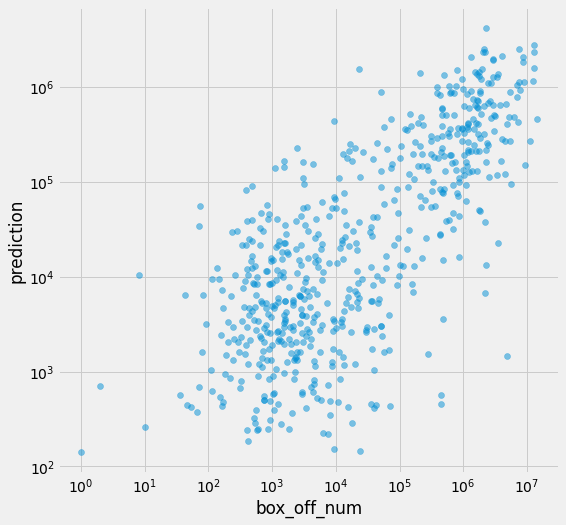

In [39]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')

### 2차 다항회귀 (Polynomial Regression)

In [40]:
from sklearn.preprocessing import PolynomialFeatures

In [41]:
# 7개의 변수가 36개가 되었다
#오버피팅의 문제가 있을 수 있다.
poly = PolynomialFeatures(2)
X = poly.fit_transform(df[num_cols])
print(X.shape)

(600, 36)


In [42]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

print(f' RMSE:\t{rmse(df[target_col], df[pred_col]):12.2f}')
print(f'RMLSE:\t{rmlse(df[target_col], df[pred_col]):12.2f}')

 RMSE:	  2925430.09
RMLSE:	        2.00


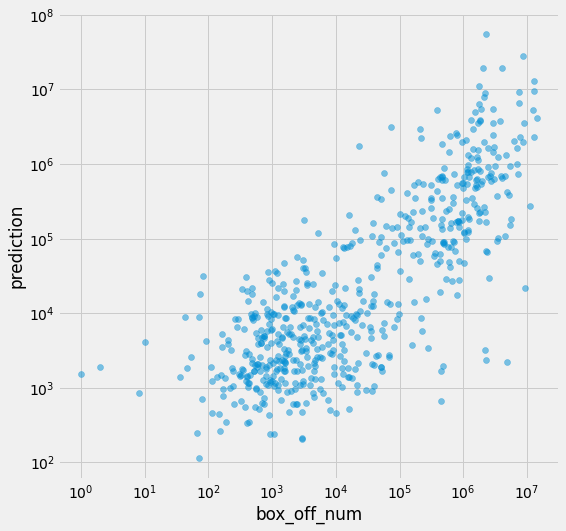

In [43]:
plt.figure(figsize=(8, 8))
plt.scatter(df[target_col], df[pred_col], alpha=.5)
plt.xlabel('box_off_num')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')